## Import Libraries

In [2]:
from scipy.io import wavfile as wav
import librosa
import sounddevice as sd
import IPython.display as ipd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import joblib
import keras
from keras.utils import np_utils

Using TensorFlow backend.


In [3]:
duration = 2 # (secondi)
rec_rate = 44100

## data load

In [275]:
# Segnaposto per feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=True):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Carica file ed estraine le features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Categorie
            label = f.split('_')[0]
            labels.append(label)
                   
    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=13)
    
    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test, X_train_mean, X_train_std

In [276]:
def mfcc(input, rate=rec_rate):
    # Calcola coefficienti MFCC
    mfcc = librosa.feature.mfcc(input*1.0, sr=int(rate), n_mfcc=30)
    # Appiattisci rappresentazione per uso con SVM
    #mfcc = mfcc.flatten()
    return mfcc

In [277]:
# Caricamento dati
X_train, X_test, y_train, y_test, X_train_mean, X_train_std = load_data(feature_extractor=mfcc)

In [278]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [279]:
Y_train = np_utils.to_categorical(y_train,4)
Y_test = np_utils.to_categorical(y_test,4)

## Model

In [397]:
 def make_model():
  model = keras.Sequential([
      keras.layers.LSTM(16, activation='relu',dropout = 0.3, recurrent_dropout = 0.3, return_sequences= True, input_shape=(30, 173, )),
      #keras.layers.Dropout(0.5),
      keras.layers.LSTM(64, dropout = 0.3, recurrent_dropout = 0.3, return_sequences= False, activation='relu'),
      #keras.layers.Dropout(0.5),
      keras.layers.Dense(4, activation='softmax'),
  ])
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.categorical_crossentropy,
  metrics=['accuracy'])

  return model

In [398]:
model = make_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 16)            12160     
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 260       
Total params: 33,156
Trainable params: 33,156
Non-trainable params: 0
_________________________________________________________________


In [399]:
baseline_history = model.fit(
    X_train,
    Y_train,
    epochs=300)

Epoch 1/300
112/112 [==============================] - 3s 28ms/step - loss: 1.4437 - accuracy: 0.2589
Epoch 2/300
112/112 [==============================] - 0s 4ms/step - loss: 1.3611 - accuracy: 0.3393
Epoch 3/300
112/112 [==============================] - 1s 5ms/step - loss: 1.3144 - accuracy: 0.3661
Epoch 4/300
112/112 [==============================] - 1s 5ms/step - loss: 1.1668 - accuracy: 0.5179
Epoch 5/300
112/112 [==============================] - 1s 5ms/step - loss: 1.1690 - accuracy: 0.4196
Epoch 6/300
112/112 [==============================] - 1s 5ms/step - loss: 1.1551 - accuracy: 0.4911
Epoch 7/300
112/112 [==============================] - 1s 5ms/step - loss: 1.3095 - accuracy: 0.4196
Epoch 8/300
112/112 [==============================] - 1s 5ms/step - loss: 1.0452 - accuracy: 0.4732
Epoch 9/300
112/112 [==============================] - 1s 5ms/step - loss: 0.9256 - accuracy: 0.6518
Epoch 10/300
112/112 [==============================] - 1s 5ms/step - loss: 1.1444 - accur

112/112 [==============================] - 1s 6ms/step - loss: 0.3604 - accuracy: 0.9107
Epoch 161/300
112/112 [==============================] - 1s 6ms/step - loss: 0.2826 - accuracy: 0.9018
Epoch 162/300
112/112 [==============================] - 1s 5ms/step - loss: 0.4180 - accuracy: 0.8750
Epoch 163/300
112/112 [==============================] - 1s 6ms/step - loss: 0.1837 - accuracy: 0.9464
Epoch 164/300
112/112 [==============================] - 1s 6ms/step - loss: 0.2812 - accuracy: 0.9107
Epoch 165/300
112/112 [==============================] - 1s 6ms/step - loss: 0.1502 - accuracy: 0.9554
Epoch 166/300
112/112 [==============================] - 1s 6ms/step - loss: 0.1600 - accuracy: 0.9554
Epoch 167/300
112/112 [==============================] - 1s 6ms/step - loss: 0.1840 - accuracy: 0.9554
Epoch 168/300
112/112 [==============================] - 1s 6ms/step - loss: 0.2067 - accuracy: 0.9464
Epoch 169/300
112/112 [==============================] - 1s 6ms/step - loss: 0.1632 - a

Report di classificazione modello:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       0.69      0.69      0.69        13
           2       0.67      0.67      0.67        12
           3       1.00      0.91      0.95        11

    accuracy                           0.81        48
   macro avg       0.82      0.82      0.82        48
weighted avg       0.81      0.81      0.81        48

Matrice di confusione modello:
[[12  0  0  0]
 [ 0  9  4  0]
 [ 0  4  8  0]
 [ 1  0  0 10]]


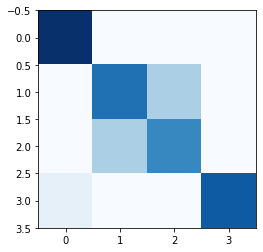

In [400]:
y_pred = model.predict_classes(X_test) 
y_test = y_test.astype("int")
# Report di classificazione
print("Report di classificazione modello:")
print(classification_report(y_test, y_pred))

# Matrice di confusione
print("Matrice di confusione modello:")
cm = confusion_matrix(y_test, y_pred)
print(cm)
plt.imshow(cm, cmap=plt.cm.Blues)

## Demo

In [581]:
prova = sd.rec(int(duration * rec_rate), samplerate=rec_rate, channels=1, blocking=True)

In [582]:
wav.write('test.wav', rate=rec_rate, data=(prova))
rec_rate, rec = wav.read('test.wav')

In [584]:
mfcc = librosa.feature.mfcc(rec*1.0, sr=rec_rate, n_mfcc=30)
eps=0.001
mfcc = (mfcc - X_train_mean + eps)/(X_train_std + eps)
mfcc = mfcc.reshape(1,mfcc.shape[0],mfcc.shape[1])

In [587]:
preds_audio = model.predict(mfcc)

In [589]:
if max(preds_audio[0]) < 0.7:   
    preds_audio = 4  
else:   
    preds_audio = np.argmax(preds_audio)

In [590]:
if preds_audio==0:
    print("Raffaele ha detto acconsento")
    
elif preds_audio == 1:
    print("Raffaele ha detto non acconsento")

elif preds_audio == 2:
    print("Lorenzo ha detto acconsento")
    
elif preds_audio == 3:
    print("Lorenzo ha detto non acconsento")
    
else:
    print("qualcuno che non conmosco ha detto dio porco")

qualcuno che non conmosco ha detto dio porco


In [188]:
ipd.Audio(prova[:,0], rate=44100)